# Demo Video smooth version

In [1]:
from LK_optical_flow.utils import showarray
from two_stream import Two_stream

import os, sys, cv2, time
old_stdout = sys.stdout

import configparser
import numpy as np

from contextlib import contextmanager

@contextmanager
def silence_stdout():
    old_target = sys.stdout
    try:
        with open(os.devnull, "w") as new_target:
            sys.stdout = new_target
            yield new_target
    finally:
        sys.stdout = old_target
        

In [2]:
## configs
config = configparser.ConfigParser()
config.read('./files/config.config')

size = (ch,h,w) = (config['OpticalFlow']['channel'],
                   int(config['DataConfig']['image_height']),int(config['DataConfig']['image_width'])) #(20,256,256)

fps_list = []
start,end,sec = 0,0,1e-4

In [3]:
import ctypes
import numpy as np
import multiprocessing as mp

from multiprocessing import Process

def action_recogn_job(curr_frame, prev_frame, output):
    global two_stream
    
    with silence_stdout():
        output[:] = two_stream(curr_frame, prev_frame)

output = mp.Array(ctypes.c_float, 101)
ps_two_stream = None #Process(target=self.spatial_job, args=(input_frame, 0))


In [4]:
two_stream = Two_stream('./files/config.config')

	[Info] buff depth 65536
	[Info] buff depth 131072
	[Info] buff depth 131072
memory allocation...
memory allocation...: done
	[Info] buff depth 131072
memory allocation...
memory allocation...: done
	[Info] buff depth 131072
memory allocation...
memory allocation...: done
	[Info] buff depth 131072
memory allocation...
memory allocation...: done
	[Info] buff depth 131072
memory allocation...
memory allocation...: done
	[Info] buff depth 131072
	[Info] buff depth 131072
	[Info] buff depth 131072
	[Info] buff depth 65536
shape of wgt:  (32, 16, 3, 3)
shape of wgt:  (64, 32, 3, 3)
shape of wgt:  (64, 64, 3, 3)
shape of wgt:  (64, 64, 3, 3)
shape of wgt:  (64, 64, 3, 3)
	[Info] buff depth 131072
memory allocation...
memory allocation...: done
	[Info] buff depth 131072
memory allocation...
memory allocation...: done
	[Info] buff depth 131072
memory allocation...
memory allocation...: done
	[Info] buff depth 131072
memory allocation...
memory allocation...: done
	[Info] buff depth 131072
memo

In [5]:
delay_list = []
def demo(video_path='LK_optical_flow/files/Big.Buck.Bunny.mp4'):
    global sec, output, ps_two_stream, h, w
    
    # put demo video
    cap = cv2.VideoCapture(video_path)

    prev_frame = np.zeros((h,w,3)).astype(np.uint8)
    prev_frame_gray = np.zeros((h,w)).astype(np.uint8)
    while(True):
        start = time.time()

        ret,frame = cap.read()
        if ret:            
            curr_frame = cv2.resize(frame, (h, w))
            curr_frame = cv2.cvtColor(curr_frame, cv2.COLOR_BGR2RGB)
            curr_frame_gray = cv2.cvtColor(curr_frame, cv2.COLOR_RGB2GRAY)
            
            start = time.time()
            
            # luccas kannade , fbank
            vx,vy = two_stream.lucas_kanade_acc.compute(prev_frame_gray, curr_frame_gray)
            
            end = time.time()
            delay_list.append(end-start)
            
            two_stream.feature_bank.push(vx,vy)
            
#             action_recogn_job(curr_frame, prev_frame, output)
            if ps_two_stream==None or not ps_two_stream.is_alive():
                ps_two_stream = Process(target=action_recogn_job, args=(curr_frame, prev_frame, output))
                ps_two_stream.start()

            ## class 
            k = 3
            pred_action = np.argpartition(np.array(output), -k)[-k:]+1 #top-k

            prev_frame = curr_frame
            prev_frame_gray = curr_frame_gray

            ####################
            ##### just show ####
            vx = np.expand_dims(vx, axis=2)
            vy = np.expand_dims(vy, axis=2)
            #vv = np.sqrt((vx**2+vy**2))
            vv = np.zeros((h,w,1))
            v = np.concatenate((vv,vx,vy),axis=2).astype(np.uint8)
            
            gt = video_path[video_path.find("v_")+2:video_path.find("_g")]
            showarray(np.concatenate((curr_frame,v),axis=1), 1/sec, topk=pred_action, gt=gt)
            ####################
            #showarray(curr_frame, 1/sec, show_meta=False)
        else:
            break

        end = time.time()
        sec = end-start
        fps_list.append(1/sec)
        #print(sec)

    print(f"avg fps:{sum(fps_list)/len(fps_list)}")


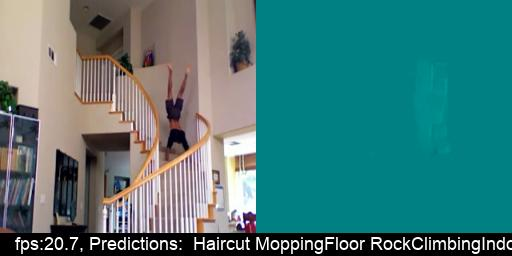

Process Process-2313:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-3-5313a6d64bf1>", line 10, in action_recogn_job
    with silence_stdout():
  File "/usr/lib/python3.6/contextlib.py", line 81, in __enter__
    return next(self.gen)
  File "<ipython-input-1-8d74bcda5478>", line 16, in silence_stdout
    with open(os.devnull, "w") as new_target:
KeyboardInterrupt


KeyboardInterrupt: 

In [7]:
import random
import glob


# video_candidate0 = ['LK_optical_flow/files/v_BaseballPitch_g17_c05.avi',
#                     'LK_optical_flow/files/v_BaseballPitch_g17_c01.avi',
#                    'LK_optical_flow/files/v_BaseballPitch_g17_c02.avi',
#                    'LK_optical_flow/files/v_BaseballPitch_g17_c03.avi']
# for vd in video_candidate0:
#     demo(vd)
    
video_candidate1 = glob.glob('LK_optical_flow/files/*.avi')
random.shuffle(video_candidate1)

for vd in video_candidate1:
    demo(vd)


In [ ]:
 sum(delay_list)/len(delay_list)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

y = np.array([4.633, 119, 3.58, 0.000151, 193, 11.57])/1000
x_label = ['frame_preprocess','spatial_cnn','luccas_kanade','fbank_addr','temporal_cnn','render']
x_color = ['red','blue','green','green','green','red']

plt.ylabel('sec',fontsize=16)
plt.xlabel('component',fontsize=16)
plt.xticks(np.arange(len(y)), x_label, rotation=45, fontsize=14)
plt.xticks(fontsize=14)

for ticklabel, tickcolor in zip(plt.gca().get_xticklabels(), x_color):
    ticklabel.set_color(tickcolor)

plt.bar(range(len(y)),y, color=x_color)

plt.show()
